# Optimization for Collabrative filtering

# A. Preprocessing of data

1. Data format

We are going to preprocess a rating file in the following csv format:  
```
UserID::MovieID::Rating::Timestamp
```

2. Prepare data for cross-validation

Splitting Data for a user-based N-fold cross-validation. Store each partition into a new csv file. 

It is convinient to use a python package lenskit. It can be installed by following https://lkpy.readthedocs.io/en/stable/install.html

Use the function lenskit.crossfold.partition_rows to partition all the ratings into N train-test partitions.

3. Convert to a list format

Convert data into a list format for fast processing


In [11]:
!pip install lenskit

In [228]:
import pandas as pd

# read a DataFrame of ratings from the csv ratings file
csvroot = 'data'
ratings = pd.read_csv(csvroot + '/ratings.csv')
#ratings = ratings.iloc[:1000]
ratings = ratings.rename(columns={'userId': 'user', 'movieId': 'item'})

def unique(list1):
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    # use a dictionary to store the index of eac element in the list
    unique_dict = {}
    for i in range(len(unique_list)):
        unique_dict[unique_list[i]] = i 
    return unique_list, unique_dict

lst_users, dic_users = unique(ratings['user'])
lst_items, dic_items = unique(ratings['item'])

M = len(lst_users)
N = len(lst_items)
matrixSparsity = len(ratings) / (M*N)
print("We have %d users, %d movies and the rating matrix has %f percent of non-zero value.\n" % (M, N, 100*matrixSparsity))

We have 610 users, 9724 movies and the rating matrix has 1.699968 percent of non-zero value.



In [229]:
len(ratings)

100836

In [230]:
# 2 fold cross-validation, store each partition (both train and test) in a seperate csv file.
# Point 1: report the number of (user,iter,rating) items in each file.

import lenskit.crossfold as xf

nbSample = 0
for train, test in xf.sample_rows(ratings, 5, 20000):
    train.to_csv(csvroot + '/train-%d.csv' % (nbSample,))
    print(f'train{nbSample} : {len(train)} lines')
    test.to_csv(csvroot + '/test-%d.csv' % (nbSample,))
    print(f'test{nbSample} : {len(test)} lines')
    nbSample += 1


train0 : 80836 lines
test0 : 20000 lines
train1 : 80836 lines
test1 : 20000 lines
train2 : 80836 lines
test2 : 20000 lines
train3 : 80836 lines
test3 : 20000 lines
train4 : 80836 lines
test4 : 20000 lines


In [231]:
def convert_DF_to_RDD(DF):
    """ 
    This function converts a rating dataframe into a dictionary of lists
    Args:
        DF: a dataframe which contains 'user', 'item' and 'rating' columns
    Returns:
        RDD: a dictionary which contains 
            'total': the total number of rating
            'users': a list of user id for each rating
            'items': a list of item id for each rating
            'ratings': a list of ratings
    """ 
    RDD = {'total':0,'users':[],'items':[],'ratings':[]} 
    
    for i in range(len(DF)):
        RDD['total'] += 1
        RDD['users'].append(DF.user[i])
        RDD['items'].append(DF.item[i])
        RDD['ratings'].append(DF.rating[i])
    
    return RDD

In [232]:
# read the csv files from a partition of the cross-validation
# convert them to RDD using convert_DF_to_RDD

train = convert_DF_to_RDD(pd.read_csv(csvroot + '/train-0.csv'))
test = convert_DF_to_RDD(pd.read_csv(csvroot + '/test-0.csv'))


# B. Gradient-descent algorithm

Based on the preprocessing, we are going to develop a method to find optimal P and Q on training data. It contains: 

1. compute the objective and the gradient of the objective function
2. implement the gradient-descent algroithm
3. measure the speed of this method

In [233]:
# assume now you have obtained trainRDD and testRDD
# Compute the objective funtion

import numpy as np

def computeMSE(RDD,P,Q,la=0):
    """ 
    This function computes regularized Mean Squared Error (MSE)
    Args:
        RDD: a dict of list of userID, itemID, Rating
        P: user's features matrix (M by K)
        Q: item's features matrix (N by K)
        la: lambda parameter for regulization (see definition in the project description)
    Returns:
        mse: mean squared error
    """ 
    
    se = 0
    ratings = RDD['ratings']
    users = RDD['users']
    items = RDD['items']
    total = RDD['total']
    for n in range(total):
        r = ratings[n]
        i = dic_users[users[n]]
        j = dic_items[items[n]]
        hQ = np.copy(Q[j,:])
        hQ[hQ < 0] = 0
        hP = np.copy(P[i,:])
        hP[hP < 0] = 0
        se += (r - Q[j,:].T @ P[i,:])**2 + la * (np.linalg.norm(hP)**2 + np.linalg.norm(hQ)**2)
    
    return se / total
    

In [234]:
# use a random P and Q to test the function computeMSE
# Point 2: report MSE with LAMBDA=0

K = 5 # rank parameter
P = np.random.rand(M,K) # user's features matrix (M by K)
Q = np.random.rand(N,K) # item's features matrix (N by K)

computeMSE(train, P, Q)

6.287630264039132

In [235]:
# Compute the gradient of the objective funtion
def computeGradMSE(RDD,P,Q,la=0):
    """ 
    This function computes the gradient of regularized MSE with respect to P and Q
    Args:
        RDD: a dict of list of userID, itemID, Rating
        P: user's features matrix (M by K)
        Q: item's features matrix (N by K)
    Returns:
        gradP, gradQ: gradient of mse with respect to each element of P and Q 
    """ 
    
    gradP = np.zeros(P.shape)
    gradQ = np.zeros(Q.shape)
    ratings = RDD['ratings']
    users = RDD['users']
    items = RDD['items']
    total = RDD['total']
    for n in range(total):
        r = ratings[n]
        i = dic_users[users[n]]
        j = dic_items[items[n]]
        hQ = np.copy(Q[j,:])
        hQ[hQ < 0] = 0
        hP = np.copy(P[i,:])
        hP[hP < 0] = 0
        e = -2 * (r - Q[j,:].T @ P[i,:]) 
        for k in range(P.shape[1]):
            gradP[i,k] = e * Q[j,k] + 2 * la * hP[k]
            gradQ[j,k] = e * P[i,k] + 2 * la * hQ[k]
    
    return gradP, gradQ
    

In [236]:
computeGradMSE(train, P, Q, 0.1)

(array([[-0.63749001, -1.35211286, -5.09386726, -1.82249833, -4.54167879],
        [-0.30013148, -5.15333195, -0.01177902, -3.29502286, -5.52606383],
        [ 0.57506714,  0.43983734,  0.27324886,  0.06447657,  0.20841383],
        ...,
        [-4.13990781, -3.46652955, -3.11515344, -2.89159613, -5.08593705],
        [-1.4101086 , -0.98338728, -1.39391865, -0.4397106 , -1.80678087],
        [-1.51969905, -0.60668252, -2.8765921 , -3.93230176, -0.48709817]]),
 array([[-1.51151031e-01, -3.25205597e+00, -5.13166428e-01,
         -3.79534219e+00, -1.77634787e+00],
        [-2.11912321e+00, -1.83450120e+00, -2.97056331e+00,
         -4.46043656e+00, -2.48484670e-02],
        [-5.02568227e-01, -7.43760544e-01, -2.75276009e+00,
         -1.85384274e-02, -1.92675965e+00],
        ...,
        [-1.94432986e+00, -7.43259325e-01, -1.64909482e+00,
         -5.84172559e-01, -2.40208820e+00],
        [-5.11377546e+00, -5.39300020e+00, -2.39915443e+00,
         -6.49874916e-01,  1.36302495e-01],
  

In [237]:
# implement the (steepest) gradient-descent algorithm
from tqdm import tqdm

def backtraking(RDD, P, Q, gradP, gradQ, beta):
    alpha = 1
    while computeMSE(RDD, P - alpha * gradP, Q - alpha * gradQ) > computeMSE(RDD, P, Q):
        alpha *= beta
    return alpha
    

def GD(RDD,M,N,K,MAXITER=50, GAMMA=0.001, LAMBDA=0.05, adaptive=0):
    """ 
    This function implemnts the gradient-descent method to minimize the regularized MSE with respect to P and Q
    Args:
        RDD: a dict of list of users, items, ratings
        M: number of users
        N: number of items
        K: rank parameter
        MAXITER: maximal number of iterations (epoches) of GD 
        GAMMA: step size of GD
        LAMBDA: regulization parameter lambda in the mse loss
        adaptive: if 0 then use constant step size GD, 
                  if 1 then use line search to choose the step size automatically
    Returns:
        P: optimal P found by GD
        Q: optimal Q found by GD
        lreg_mse: a list of regulized mse values evaluated on RDD, after each iteration
        lmse: a list of mse values, evaluated on RDD after each iteration
        other scores for analysis purpose
    """
    tol = 0.005
    lreg_mse = []
    lmse = []
    P = np.random.rand(M,K)
    Q = np.random.rand(N,K) 
    alpha = GAMMA
    gradP, gradQ = computeGradMSE(RDD, P, Q, LAMBDA)
    normP0 = np.linalg.norm(gradP)
    normQ0 = np.linalg.norm(gradQ)
    for k in tqdm(range(MAXITER)):
        saveP = P.copy()
        saveQ = Q.copy()
        if adaptive == 1:
            alpha = backtraking(RDD, P, Q, gradP, gradQ, 0.1)
        P -= alpha * gradP
        Q -= alpha * gradQ
        reg_mse = computeMSE(RDD, P, Q, LAMBDA)
        lreg_mse.append(reg_mse)
        mse = computeMSE(RDD, P, Q, 0)
        lmse.append(computeMSE(RDD, P, Q, 0))
        gradP, gradQ = computeGradMSE(RDD, P, Q, LAMBDA)
        
        vanish = np.linalg.norm(gradP) <= tol * (normP0 + tol) and np.linalg.norm(gradQ) <= tol * (normQ0 + tol)
        stag = np.linalg.norm(P - saveP) <= tol * (np.linalg.norm(P) + tol) and np.linalg.norm(Q - saveQ) <= tol * (np.linalg.norm(Q) + tol)

        if vanish or stag:
            break
    
    return P, Q, lreg_mse, lmse
    

 92%|█████████▏| 183/200 [00:10<00:00, 17.60it/s]


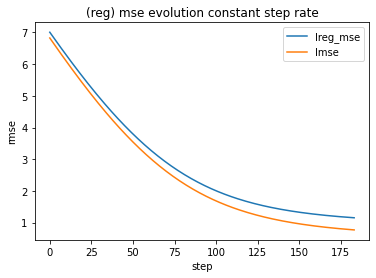

In [188]:
# Compare GD constant step size with GD line search step size
# Point 3: Make plots to show how (regularized) MSE changes with respect to GD iterations 
# Mention your initialization of P,Q, and the stopping criterion of GD

import matplotlib.pyplot as plt

P, Q, lreg_mse, lmse = GD(train,M,N,K,MAXITER=200, GAMMA=0.001, LAMBDA=0.05, adaptive=0)

plt.plot(lreg_mse)
plt.plot(lmse)
plt.ylabel('rmse')
plt.xlabel('step')
plt.title('(reg) mse evolution constant step rate')
plt.gca().legend(('lreg_mse','lmse'))
plt.show()

 10%|█         | 5/50 [01:14<11:11, 14.93s/it]


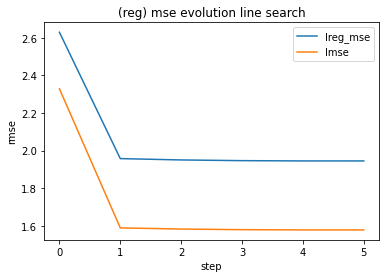

In [225]:
P, Q, lreg_mse, lmse = GD(train,M,N,K,MAXITER=50, GAMMA=0.001, LAMBDA=0.05, adaptive=1)

plt.plot(lreg_mse)
plt.plot(lmse)
plt.ylabel('rmse')
plt.xlabel('step')
plt.title('(reg) mse evolution line search')
plt.gca().legend(('lreg_mse','lmse'))
plt.show()

# C. Performance evaluation
1. Compute RMSE score. You should use lenskit.metrics.predict.rmse for a fair comparison. Analyze both the training and test score on the 5 cross-validation partitions. 
2. Compare with a baseline method called Bias. Tune the hyper-parameters such as K and lambda to see if you can obtain a smaller RMSE. Try to explain why. 

In [241]:
# Point 4: Report RMSE, together with your choice of K,LAMBDA and GD parameters

from lenskit.metrics.predict import user_metric, rmse

def evaluteRMSE(RDD,P,Q):
    """ 
    This function computes the root MSE score on the rating of RDD. It compares the rating of each (i,j)
    in RDD, with the prediction made by <p_i,q_j>. 
    Args:
        RDD: a dict of list of users, items, ratings
        P: optimal P found by GD
        Q: optimal Q found by GD
    Returns:
        RMSE: the RMSE score
    """
    
    return np.sqrt(computeMSE(RDD,P,Q))

#for i in range(nbSample):
#    print(f'Sample {i} :')
#    train = convert_DF_to_RDD(pd.read_csv(csvroot + f'/train-{i}.csv'))
#    test = convert_DF_to_RDD(pd.read_csv(csvroot + f'/test-{i}.csv'))
#    P, Q, lreg_mse, lmse = GD(train,M,N,K,MAXITER=50, GAMMA=0.001, LAMBDA=0.05, adaptive=1)
#    print(f'- train RMSE = {evaluteRMSE(train,P,Q)}')
#    print(f'- test RMSE = {evaluteRMSE(test,P,Q)}')



In [242]:
# Compare the performance with a baseline method called Bias
# see in https://lkpy.readthedocs.io/en/stable/bias.html
# Point 5:  report the RMSE of the baseline method, and analyze the results
# Hint: use read_csv in panda to read you csv data

from lenskit.algorithms.bias import Bias
from lenskit.batch import predict

train = pd.read_csv(csvroot + f'/train-0.csv')
test = pd.read_csv(csvroot + f'/train-0.csv')
algo = Bias()
algo.fit(train)
preds = predict(algo, test)
user_metric(preds, metric=rmse)


0.8069002440075873